<a href="https://colab.research.google.com/github/pranitj8898/detection_on_GroceryDataset/blob/main/Bertlabs_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tensorboardX

# **Collecting the Data Sources**

Part 1 Dataset

In [6]:
!wget -q https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
!tar xf ShelfImages.tar.gz

Part 2 Dataset

In [7]:
!wget -q https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz
!tar xf GroceryDataset_part2.tar.gz

In [8]:
!ls -lh ShelfImages | head -10
!ls -lh ShelfImages/train | head -10
!ls -lh ShelfImages/test | head -10

total 16K
drwxrwxr-x 2 1001 1001 4.0K Jan  9 08:24 test
drwxrwxr-x 2 1001 1001  12K Jan  9 08:24 train
total 456M
-rw-r--r-- 1 1001 1001  645K Oct 23  2019 C1_P01_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N1_S2_2.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001  870K Oct 23  2019 C1_P01_N1_S3_2.JPG
-rw-r--r-- 1 1001 1001  907K Oct 23  2019 C1_P01_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001  1.3M Oct 23  2019 C1_P01_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N2_S4_1.JPG
-rw-r--r-- 1 1001 1001  2.0M Oct 23  2019 C1_P01_N3_S2_1.JPG
total 101M
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P02_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001 1.3M Oct 23  2019 C1_P03_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P03_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001 2.4

        c := camera id (1: iPhone5S, 2: iPhone4, 3: Sony Cybershot, 4: Nikon Coolpix)
        p := planogram id
        n := the rank of the top shelf on the image according to the planogram
        s := number of shelves on the image
        i := copy number

       format= C<c>_P<p>_N<n>_S<s>_<i>.JPG

       

**Importing Libs**

In [9]:
from imutils import paths
from typing import List
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import torch

print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


Using torch 2.1.0+cu121 CPU


**Raw Images Visualization**

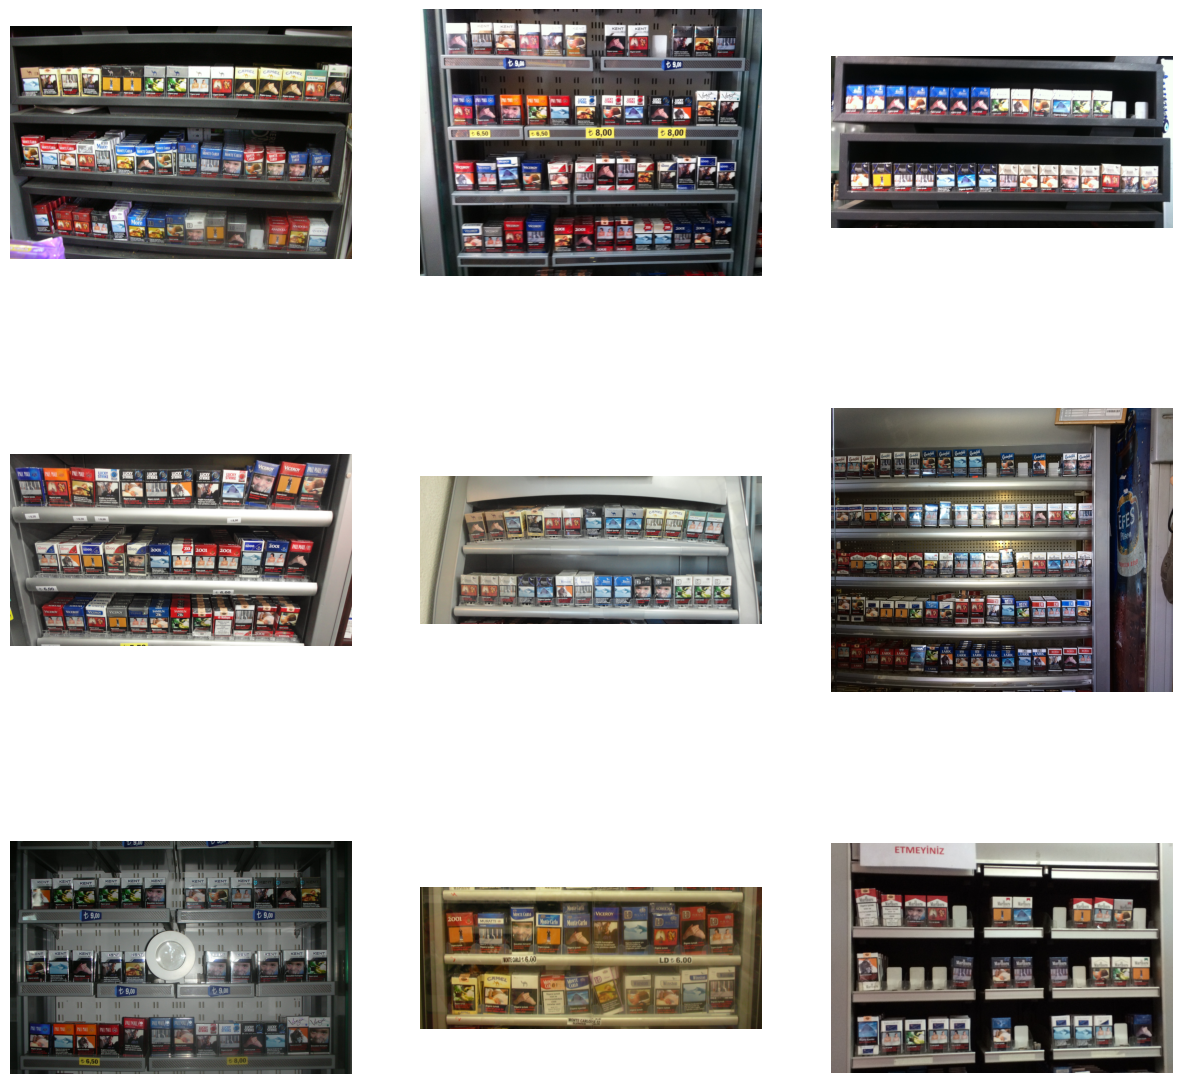

In [10]:
train_images = list(paths.list_images("ShelfImages/train"))
plt.figure(figsize=(15, 15))
for i, image  in enumerate(train_images[:9]):
    image = plt.imread(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

**annotations**

In [11]:
cols = ["image_name", "x_i", "y_i", "w_i", "h_i", "b_i"]
annotation_df = pd.read_csv("https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv",
                        names=cols)
annotation_df.head()

,image_name,x_i,y_i,w_i,h_i,b_i
0,C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0
1,C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0
2,C1_P01_N1_S2_1.JPG,24,872,268,1264,0
3,C1_P01_N1_S2_1.JPG,280,1568,532,1944,0
4,C1_P01_N1_S2_1.JPG,292,872,544,1248,0


unique brands

In [12]:
#unique brands
annotation_df["b_i"].unique()

array([ 0,  1,  4,  7,  3,  6, 10,  2,  5,  8,  9])

0 means others brand

In [13]:
#Converts bounding box to matplotlib format, imposes it on the provided image and then displays the plot.
def vis_annotations(image_path: str, coordinate_list: List[List[int]],
                    color: str="blue") -> None:

    image = plt.imread(image_path)
    fig = plt.imshow(image)
    for i in range(len(coordinate_list)):
        bbox = coordinate_list[i]
        fig.axes.add_patch(plt.Rectangle(
            xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
            fill=False, edgecolor=color, linewidth=2))
    plt.show()


**Splliting into Train and Test Dataset**

In [14]:
# Grab the image names belonging to the train and test sets
train_images = list(paths.list_images("ShelfImages/train"))
test_images = list(paths.list_images("ShelfImages/test"))
train_image_names = [image_path.split("/")[-1] for image_path in train_images]
test_image_names = [image_path.split("/")[-1] for image_path in test_images]
print(len(train_image_names), len(test_image_names))

283 71


In [15]:
# Create two different dataframes from train and test sets
train_df = annotation_df[annotation_df["image_name"].isin(train_image_names)]
test_df = annotation_df[~annotation_df["image_name"].isin(train_image_names)]
print(len(np.unique(train_df["image_name"])), len(np.unique(test_df["image_name"])))

283 71


In [16]:
# Let's turn the image names into absolute paths
train_df["image_name"] = train_df["image_name"].map(lambda x: "ShelfImages/train/" + x)
test_df["image_name"] = test_df["image_name"].map(lambda x: "ShelfImages/test/" + x)

<ipython-input-16-5339d736f7f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["image_name"] = train_df["image_name"].map(lambda x: "ShelfImages/train/" + x)
<ipython-input-16-5339d736f7f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["image_name"] = test_df["image_name"].map(lambda x: "ShelfImages/test/" + x)


In [17]:
# Preview
train_counts = len(train_df['image_name'].unique())
test_counts = len(test_df['image_name'].unique())
print(f'Total Unique train images {train_counts}')
print(f'Total Unique test images {test_counts}')


Total Unique train images 283
Total Unique test images 71


**Data Preperation**

In [18]:
# it takes class label, xy, wh
def form_line(cls, x, y, w, h):
  line = str(cls)+' '+ str(x) +' '+ str(y) + ' ' + str(w) + ' ' + str(h) + '\n'
  return line

In [19]:
train_df['b_i'].unique()

array([ 0,  1,  4,  7,  3,  6, 10,  2,  5,  8,  9])

In [20]:
# fetch list of train images in the shelf images dataset
train_images = sorted(train_df['image_name'].unique())
# fetch list of test images in the shelf images dataset
test_images = sorted(test_df['image_name'].unique())

# destination train image path
dst_train_path = os.path.join('/content/Prep_data/train', 'images')
# destination test image path
dst_test_path = os.path.join('/content/Prep_data/test', 'images')
# train annotation path
annot_train = os.path.join('/content/Prep_data/train', 'labels')
# test annotation path
annot_test = os.path.join('/content/Prep_data/test', 'labels')

# prepare destination directory
if not os.path.isdir('/content/Prep_data'):
  os.mkdir('/content/Prep_data')
  # train and test path
  os.mkdir('/content/Prep_data/train')
  os.mkdir('/content/Prep_data/test')

def fetch_annotation(img_path, df):
  img_id = img_path.split('/')[-1]
  img_w, img_h = np.flip(plt.imread(img_path).shape[:2])[:2]
  lines = ''
  for record in np.array(df[df['image_name']==img_path]):
    #print(f'Image name {img_id}')
    class_label = record[-1]
    w = record[3] - record[1]
    h = record[4] - record[2]
    c_x = record[1] + (w/2)
    c_y = record[2] + (h/2)
    x_norm = c_x/(img_w)
    y_norm = c_y/(img_h)
    w_norm = w/img_w
    h_norm = h/img_h
    lines+= form_line(class_label, x_norm, y_norm, w_norm, h_norm)
  return img_id, lines

# create annotation files
def data_prep(annot_path, dst_img_path, img_paths, df):
  # if annotation folder not exists
  if not os.path.isdir(annot_path):
    os.mkdir(annot_path)
  # if seperate image folder not exists
  if not os.path.isdir(dst_img_path):
    os.mkdir(dst_img_path)

  for img_path in tqdm(img_paths):
    img = plt.imread(img_path)
    img_id, lines = fetch_annotation(img_path, df)
    plt.imsave(os.path.join(dst_img_path, img_id), img)

    img_name = img_id.split('.')[0]
    annot_img_file = os.path.join(annot_path, img_name)+'.txt'
    if not os.path.isfile(annot_img_file):
      with open(annot_img_file, 'x') as f:
        f.write(lines)

  assert len(os.listdir(annot_path)) == len(os.listdir(dst_img_path))
  print('\nCheck passed!')

In [21]:
#check train data
data_prep(annot_train, dst_train_path, train_images, train_df)

100%|██████████| 283/283 [01:20<00:00,  3.53it/s]


Check passed!


In [22]:
#check test data
data_prep(annot_test, dst_test_path, test_images, test_df)

100%|██████████| 71/71 [00:18<00:00,  3.79it/s]


Check passed!


# **Yolo v4 Enviroment setup**

In [23]:
from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


In [24]:
%cd /content
!pwd

/content
/content


In [25]:
# clone Scaled_YOLOv4
!git clone https://github.com/roboflow-ai/ScaledYOLOv4.git /content/drive/MyDrive/yolov4 # clone repo
%cd /content/drive/MyDrive/yolov4
#checkout the yolov4-large branch
!git checkout yolov4-large

fatal: destination path '/content/drive/MyDrive/yolov4' already exists and is not an empty directory.
/content/drive/MyDrive/yolov4
Already on 'yolov4-large'
Your branch is up to date with 'origin/yolov4-large'.


In [ ]:
#install mish activation funciton for cuda
%cd /content/
!git clone https://github.com/JunnYu/mish-cuda
%cd mish-cuda
!python setup.py build install

In [27]:
# install pyYaml
!pip install -U PyYAML

In [28]:
%cd ..
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat /content/drive/MyDrive/yolov4/data.yaml

/content
cat: /content/drive/MyDrive/yolov4/data.yaml: No such file or directory


In [ ]:
%cat /content/drive/MyDrive/yolov4/models/yolov4-p5.yaml

In [ ]:
# Clone the mish-cuda repository
!git clone https://github.com/JunnYu/mish-cuda.git

# Change to the mish-cuda directory
%cd mish-cuda

# Install the mish-cuda package
!python setup.py build install



In [ ]:
# train scaled-YOLOv4 on custom data for 100 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/yolov4
!python train.py --img 896 --batch 4 --epochs 30 --data '../data.yaml' --cfg '/content/drive/MyDrive/yolov4/models/yolov4-p5.yaml' --weights '/content/drive/MyDrive/yolov4/runs/exp5_yolov4-csp-results/weights/last_yolov4-csp-results_strip.pt' --nosave --name yolov4-p5-results

#**Evaluate Custom Scaled-YOLOv4 Detector Performance**

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the --name flag when we train. In our case, we named this yolov5s_results. (If given no name, it defaults to results.txt.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed results.txt files can be plotted with from utils.utils import plot_results; plot_results().

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

# **Test the Dataset**

In [ ]:
!python /content/drive/MyDrive/yolov4/test.py --img-size 896 --weights /content/drive/MyDrive/yolov4/runs/exp6_yolov4-p5-results/weights/last_yolov4-p5-results_strip.pt --data /content/drive/MyDrive/yolov4/data.yaml --save-json


In [ ]:
!python /content/drive/MyDrive/yolov4/detect.py --weights /content/drive/MyDrive/yolov4/runs/exp6_yolov4-p5-results/weights/last_yolov4-p5-results_strip.pt --source /content/Prep_data/test/images --output /content/drive/MyDrive/yolov4/test_result --img-size 896 --save-txt
